<img src="http://www.airportspotting.com/wp-content/uploads/2015/05/NewYorkCityAirports.jpg" alt="The main 3 airports of New York city" width="600"/>


### Introduction

In this notebook, I study a database of over 330 000 flights that departed from New York in 2013 for 105 different destinations in the USA to figure out which factors influence delays and which not. I will try to make an informed decision as to whether one airport is better than the others. 

This notebook is written by Mihai Munteanu in Python 3.7.5.

### Contents

1. [**Setting up the environment**](#setup)

2. [**Cleaning the data**](#cleaning)
 
3. [**Does distance of flights affect flight delays?**](#distance)
   
4. [**How to pick your favourite NY airport?**](#favourite)

5. [**Conclusion**](#conclusion)

### <a name="setup"></a>  1. Setting up the environment


Import the libraries and set up plotting settings.

In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model

pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

/Users/mihai/.pyenv/versions/3.7.5/envs/flight_data_3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/mihai/.pyenv/versions/3.7.5/envs/flight_data_3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Import the data.

In [2]:
airlines = pd.read_csv('./data/airlines.csv')
airports = pd.read_csv('./data/airports.csv')
flights = pd.read_csv('./data/flights.csv')
weather = pd.read_csv('./data/weather.csv')

### <a name="cleaning"></a>  2. Cleaning the data

In [3]:
def describe_dataframe(df):
    print('Table dimensions:', df.shape)
    
    #create table with info about dataframe data types and count of null values
    df.iloc[0:0]
    df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'data_type'})
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'#_null_values'}))
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'%_null_values'}))
    
    print('\n')
    print(df.head())
    print('\n')
    print(df_info.head())

In [4]:
describe_dataframe(airlines)

Table dimensions: (16, 2)


  carrier                    name
0      9E       Endeavor Air Inc.
1      AA  American Airlines Inc.
2      AS    Alaska Airlines Inc.
3      B6         JetBlue Airways
4      DL    Delta Air Lines Inc.


              carrier    name
data_type      object  object
#_null_values       0       0
%_null_values       0       0


In [5]:
describe_dataframe(airports)

Table dimensions: (1458, 8)


   FAA                           name   latitude  longitude  altitude  UTC  \
0  04G              Lansdowne Airport  41.130472 -80.619583      1044   -5   
1  06A  Moton Field Municipal Airport  32.460572 -85.680028       264   -6   
2  06C            Schaumburg Regional  41.989341 -88.101243       801   -6   
3  06N                Randall Airport  41.431912 -74.391561       523   -5   
4  09J          Jekyll Island Airport  31.074472 -81.427778        11   -5   

               DST          timezone  
0  US standard DST  America/New_York  
1  US standard DST   America/Chicago  
2  US standard DST   America/Chicago  
3  US standard DST  America/New_York  
4  US standard DST  America/New_York  


                  FAA    name latitude longitude altitude    UTC     DST  \
data_type      object  object  float64   float64    int64  int64  object   
#_null_values       0       0        0         0        0      0       0   
%_null_values       0       0        

In [6]:
describe_dataframe(flights)
print('\n')
print('The airport codes', (set(flights['origin']) | set(flights['destination'])) - set(airports['FAA']), 'do not exist in the airports table.')

Table dimensions: (336776, 12)


   year  month  day  departure  scheduled_departure  arrival  \
0  2013      1    1      517.0                  515    830.0   
1  2013      1    1      533.0                  529    850.0   
2  2013      1    1      542.0                  540    923.0   
3  2013      1    1      544.0                  545   1004.0   
4  2013      1    1      554.0                  600    812.0   

   scheduled_arrival carrier  flight_id origin destination  distance  
0                819      UA       1545    EWR         IAH      1400  
1                830      UA       1714    LGA         IAH      1416  
2                850      AA       1141    JFK         MIA      1089  
3               1022      B6        725    JFK         BQN      1576  
4                837      DL        461    LGA         ATL       762  


                year  month    day departure scheduled_departure  arrival  \
data_type      int64  int64  int64   float64               int64  float64   


In [7]:
print("Weather data is from:", set(weather['origin']))
print('\n')
describe_dataframe(weather)

print('\n')
print('Under 500m visibility happened for', sum(weather['visibility']<0.5), 'hours.')
print('Under 100m visibility happened for', sum(weather['visibility']<0.1), 'hours.')

Weather data is from: {'JFK', 'EWR', 'LGA'}


Table dimensions: (26115, 14)


  origin  year  month  day  hour  temperature  dewpoint  humidity  \
0    EWR  2013      1    1     1        39.02     26.06     59.37   
1    EWR  2013      1    1     2        39.02     26.96     61.63   
2    EWR  2013      1    1     3        39.02     28.04     64.43   
3    EWR  2013      1    1     4        39.92     28.04     62.21   
4    EWR  2013      1    1     5        39.02     28.04     64.43   

   wind_direction  wind_speed  wind_gust  precipitation  pressure  visibility  
0           270.0    10.35702        NaN            0.0    1012.0        10.0  
1           250.0     8.05546        NaN            0.0    1012.3        10.0  
2           240.0    11.50780        NaN            0.0    1012.5        10.0  
3           250.0    12.65858        NaN            0.0    1012.2        10.0  
4           260.0    12.65858        NaN            0.0    1011.9        10.0  


               origin   y

#### First look at tables

1. Airlines:
    - columns: carrier code, name

2. Airports: 
    - columns: FAA, name, latitude  longitude  altitude, UTC, DST, timezone
    - UTC, timezone are irrelevant as the timezone difference information is contained in the arrival and departure times.

3. Flights: 
    - columns: year, month, day, departure, scheduled_departure,  arrival, scheduled_arrival, carrier,  flight_id, origin, destination,  distance
    - type of departure/arrival is float64, while type of scheduled_departure/scheduled_arrival is int64. Will convert the former to int64.
    - the codes {'SJU', 'ERW', 'PSE', 'BQN', 'STT'} do not correspond to any airports in the airports table. All except for 'ERW' are real airports, 'ERW' is probably just a typo of 'EWR' and I will change it accordingly.  
    - 8255 flights have no departure times and 8713 have no arrival times (around 2.5% each) and will drop this data from the table as it will cause problems when computing delays.
    - **to do**:
        * add column hour to be able to join with the weather table.
        * add lat_origin, long_origin, alt_origin, lat_destination, long_destination, alt_destination columns with information from Airports.
        * drop data for the nonexistant airport codes
        * drop data for flights with not departure or no arrival times
    
    
4. Weather:
    - columns: origin,  year,  month,  day,  hour,  temperature,  dewpoint,  humidity, wind_direction,  wind_speed,  wind_gust,  precipitation,  pressure,  visibility.
    - temperature/dewpoint/humidity
        * very important on cold days/mornings as the plane will freeze and needs to be unfrozen before it can depart. One should check if morning/winter flights have larger delays than summer flights.
        * will fill in one NULL value for temperature, dewpoint, humidity with the value an hour before.       
    - wind
        * wind_speed correlated to wind_direction and the direction of the landing strip should have an impact on departing airplanes
        * wind_gusts could be very important, but the data is 80% missing, maybe because there were no wind gusts.
        * one should check whether in the 20% of the cases where we have wind_gusts data there is a correlation with bigger delays.
        * **to do**: fill all the NULL values for wind with 0
    - visibilitity
        * From the USA aviation standards: Reported in a four figure group (e.g. 0400 = 400 metres; 8000 = 8 km) up to but excluding 10 km; 9999 = 10km or more; 0000 = less than 50 metres visibility.)
        * There are 195 instances in the weather database with under 0.5km visibility, but planes can still take off if there is more than 100m of visibility. Under 100m of visibility happened only 16 instances.
        * One should check if on the 379 instances, there are significant delays.
    - precipitation
        * relevant if temperature is freezing (hence probably snow) and landing strip needs to be cleared before take off/landing or if rain is intense
    - pressure 
        * is more or less irrelevant as its variations are very small
    - hours
        * **to do**: multiply with 100 to be able to compare with hour column in flights
 

#### Doing the cleaning

In [8]:
flights.dropna(inplace=True) #dropping flights for which we don't have departure/arrival data
flights.departure = flights.departure.astype(int) 
flights.arrival = flights.arrival.astype(int)
flights = flights.replace('ERW','EWR')
flights['hour'] = flights['departure'].apply(lambda x : int((x/100))*100) #getting just the hour from the time, i.e 534 becomes 500.

In [9]:
weather.loc[:,'hour'] *= 100 #making the hour column have the same format as in flights
weather = weather.fillna(0.0) #filling the missing values with 0.0

In [10]:
#merging the flights, airports and weather data
data = pd.merge(pd.merge(pd.merge(flights, airports, how='left', left_on='origin', right_on='FAA'), 
                         airports, how='left', left_on = 'destination', right_on='FAA'), 
                weather, how = 'left', on=['origin', 'year', 'month', 'day', 'hour']) 
data = data.dropna()
working = data #create new working dataframe so we can get back to the original data in case we need it along the way
#describe_dataframe(working)

Uncomment the code in the following cell before running it, if you want to run the code only for the month of January (for quicker results).

In [11]:
#working = data[data['month'] == 1]

Since we do not have different dates for departure and arrival, we have to figure out using logic whether the flights left really late or really early. For e.g. a flight with scheduled_arrival = 2300 and arrival = 400 probably arrived really late.

In [12]:
test1 = working[working['departure']>400]
test1 = test1[test1['departure']<500]['departure'].min()
print('The earliest departure of a flight that leaves early the same day is', test1)

test2 = working[working['departure']>445]
test2 = test2[test2['departure']<600]
print('The earliest arrival of flight that left the same day is', test2['arrival'].min())

test3 = working[working['arrival']<614]
print('The latest arrival of a flight that arrives the next day is', test3[test3['arrival']>0]['arrival'].max())

test4 = working['scheduled_departure'].min()
print('The earliest scheduled_departure is', test4)

test5 = working[working['scheduled_arrival']<500]['scheduled_arrival'].max()
print('The latest scheduled arrival the next day is', test5)

The earliest departure of a flight that leaves early the same day is 445
The earliest arrival of flight that left the same day is 614
The latest arrival of a flight that arrives the next day is 551
The earliest scheduled_departure is 500
The latest scheduled arrival the next day is 241


We can conclude that all departures and scheduled_departures before 4:45 AM are one day late and all arrivals and scheduled_arrivals before 5:52 are also one day late. 

In [13]:
def to_minutes_departure(number):
    if number == 2400: minutes = 1440
    minutes = int(number/100)*60+int(number%100)
    if number < 445: minutes += 1440
    #I chose 445 = min(test1,test4)+1because no flight left later than 4:00AM and earlier than 4:45AM. 
    #The flights after 4:45AM clearly left earlier than planned that day and the one between 0:00AM and 4:00AM left late.
    return minutes

def to_minutes_arrival(number):
    if number == 2400: minutes = 1440
    minutes = int(number/100)*60+int(number%100)
    if number < 552 : minutes += 1440
    #I chose 552 = max(test3, test5)+1 because the flighno flight left later than 4:00AM and earlier than 4:45AM. 
    #The flights after 4:45AM clearly left earlier than planned that day and the one between 0:00AM and 4:00AM left late.
    return minutes

In [14]:
#compute the main culprits
working['departure_delay'] =   working['departure'].apply(to_minutes_departure) - working['scheduled_departure'].apply(to_minutes_departure)
working['arrival_delay'] =  working['arrival'].apply(to_minutes_arrival) - working['scheduled_arrival'].apply(to_minutes_arrival) 

In [15]:
#removing the useless variables
variables_to_remove = ['DST_x', 'timezone_x', 'DST_y', 'timezone_y', 'FAA_x', 'FAA_y']
working.drop(variables_to_remove, axis = 1, inplace = True)

Given that each flight has only one date, I am confused as to whether the following flights left way earlier (at least 2hours earlier) or left later the next day. Probably flight_id = 51 left early while flight_id = 172 left late the next day. I will drop these as we do not have enough info about them. 

In [16]:
#checking for more outliers in the data, for example things that seem to leave at least 2h earlier than planned.
print('Weird outliers in the data:')
print(working[working['departure_delay'] < -120][['departure','scheduled_departure', 'flight_id', 'departure_delay']])
print(working[working['arrival_delay'] < -120][['arrival','scheduled_arrival', 'flight_id', 'arrival_delay']])

Weird outliers in the data:
        departure  scheduled_departure  flight_id  departure_delay
151           848                 1835       3944             -587
7029          641                  900         51             -139
8190         1121                 1635       3695             -314
56746         603                 1645       2042             -642
82206         657                 1930       1091             -753
86178         756                 1700        172             -544
93879         830                 1845       2391             -615
94313         625                 1925       2437             -780
96166         705                 1700        172             -595
97974         734                 1725       1223             -591
121410        757                 1930       3798             -693
148270       1020                 2100       2363             -640
169361        604                 1925       1485             -801
169663       1100                 

In [17]:
indexNames = working[working['departure_delay'] < -120].index
working.drop(indexNames , inplace=True)
indexNames = working[working['arrival_delay'] < -120].index
working.drop(indexNames , inplace=True)

In [18]:
print(working[working['departure_delay']<0]['departure_delay'].count(), 'flights left early.')
print(working[working['departure_delay']>=0]['departure_delay'].count(), 'flights left late.')

178091 flights left early.
139905 flights left late.


### <a name="distance"></a> 3 Does distance of flights affect flight delays?

In this section we figure out whether the distance of a flight influences the flight delay.

#### Arrival or departure delay?

In [19]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean(), 'std': group.std()}

{'min': -43, 'max': 911, 'count': 317996, 'mean': 12.554208229034327, 'std': 39.4694200446475}


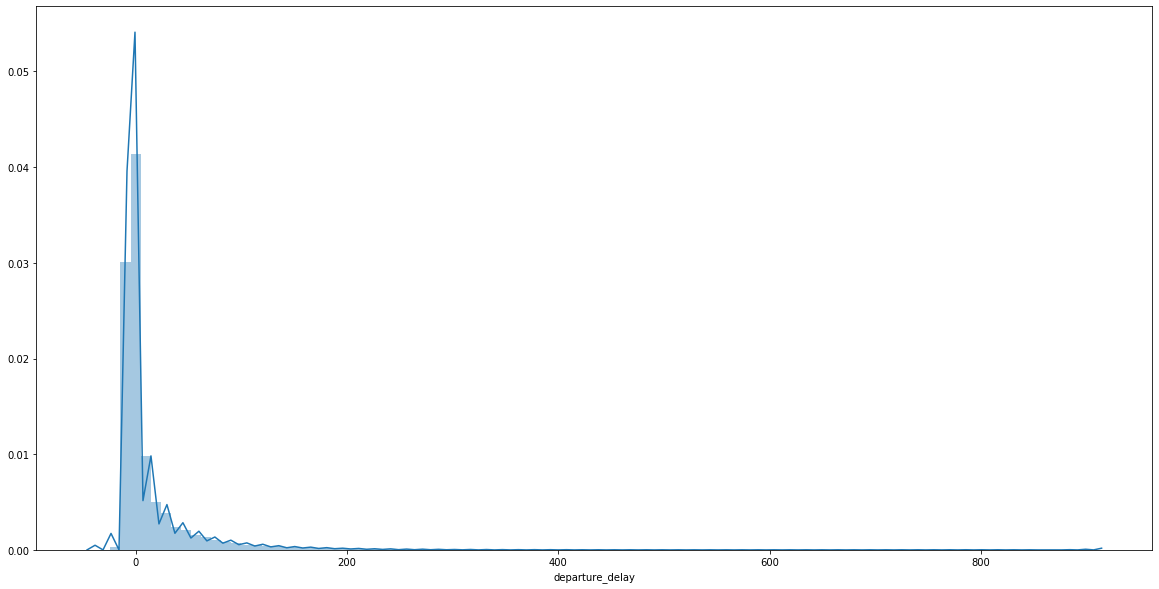

In [20]:
print(get_stats(working['departure_delay']))
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(working['departure_delay'], bins = 100)
plt.show()

As expected, delay times are exponentially decreasing, as a delay time should have the distribution of a waiting time. There is probably something weird going on with the flight that arrived 900 minutes late, but clearly this is just an outlier.

{'min': -109, 'max': 547, 'count': 317996, 'mean': -5.278817972553114, 'std': 19.76190102587499}


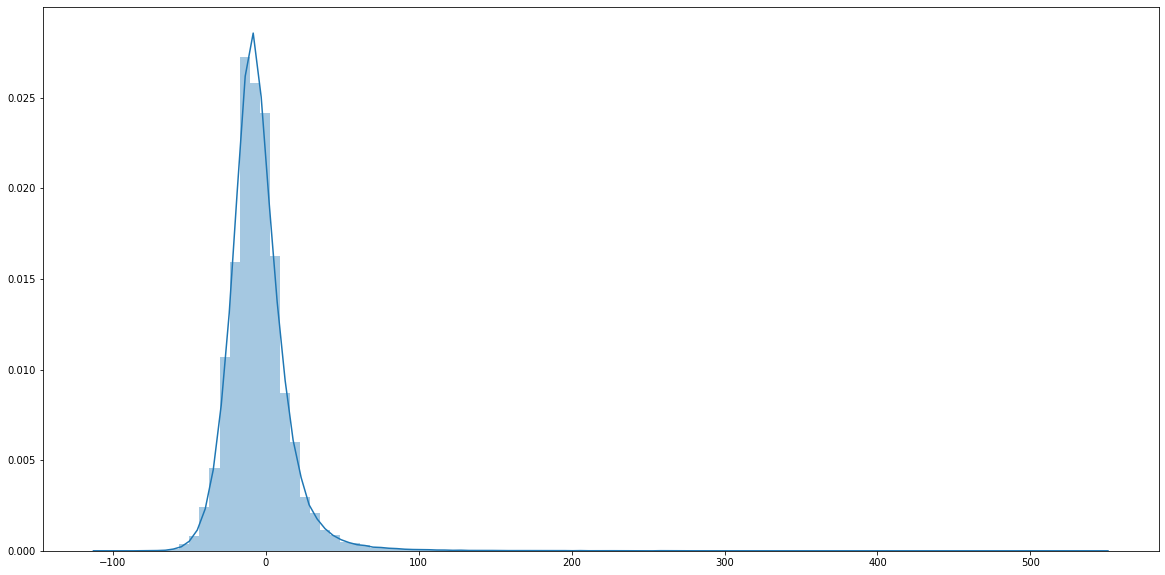

In [21]:
differences = working['arrival_delay'] - working['departure_delay']
fig, ax = plt.subplots(figsize=(20,10))
print(get_stats(differences))
sns.distplot(differences, bins = 100)
plt.show()

The differences between arrival_delays and departure_delays are normally distributed around a small negative number and that is probably due to the fact that planes tend to recover some time in the air.
This shows we can study the departure_delays because arrival_delays is highly correlated with this.

#### Are there any differences between airports?

In [22]:
def get_stats_by_category(category, interest):
    total = working['origin'].groupby(working[category]).count()
    delayed = working[working['departure_delay']>0]['departure_delay'].groupby(working[category])
    percentages = delayed.count().sort_index()/total.sort_index()
    print('Total flights by '+category)
    print(total.sort_values(ascending = False))
    print('\n')

    print('\nStats for departure delay by '+category)
    print(delayed.apply(get_stats).unstack().sort_values('count', ascending = False))
    print('\n')

    print('\nPercentages of delayed flights by '+category)
    print(percentages.sort_values(ascending = False))
    print('\n')

    print('\nStats for flight distances by '+category)
    print(working[working['departure_delay']>0][interest].groupby(working[category]).apply(get_stats).unstack().sort_values('max'))
    print('\n')

In [23]:
get_stats_by_category('origin','distance')

Total flights by origin
origin
EWR    145179
LGA    100663
JFK     72154
Name: origin, dtype: int64



Stats for departure delay by origin
        min    max    count       mean        std
origin                                           
EWR     1.0  786.0  63109.0  38.683944  51.745666
LGA     1.0  911.0  33355.0  41.413731  56.799874
JFK     1.0  636.0  27557.0  38.121457  50.913966



Percentages of delayed flights by origin
origin
EWR    0.434698
JFK    0.381919
LGA    0.331353
dtype: float64



Stats for flight distances by origin
         min     max    count         mean         std
origin                                                
LGA     96.0  1620.0  33355.0   810.231689  365.763759
EWR     80.0  4983.0  63109.0  1127.556703  789.983028
JFK     94.0  4983.0  27557.0  1248.751860  896.177745




Note that the size of airport is highly correlated with the number of delays. That is probably because flights wait in line to take off and the bigger the airport the more crowded.
Also note that planes from LGA only fly on shorter distances.

#### Considering the distances

In [24]:
def scatter_by_airport(xaxis, yaxis):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.scatterplot(x=xaxis, y=yaxis, 
                hue="origin", style="origin", legend="full", data=working)
    plt.xlabel(xaxis, fontsize = 15)
    plt.ylabel(yaxis, fontsize = 15)
    plt.show()

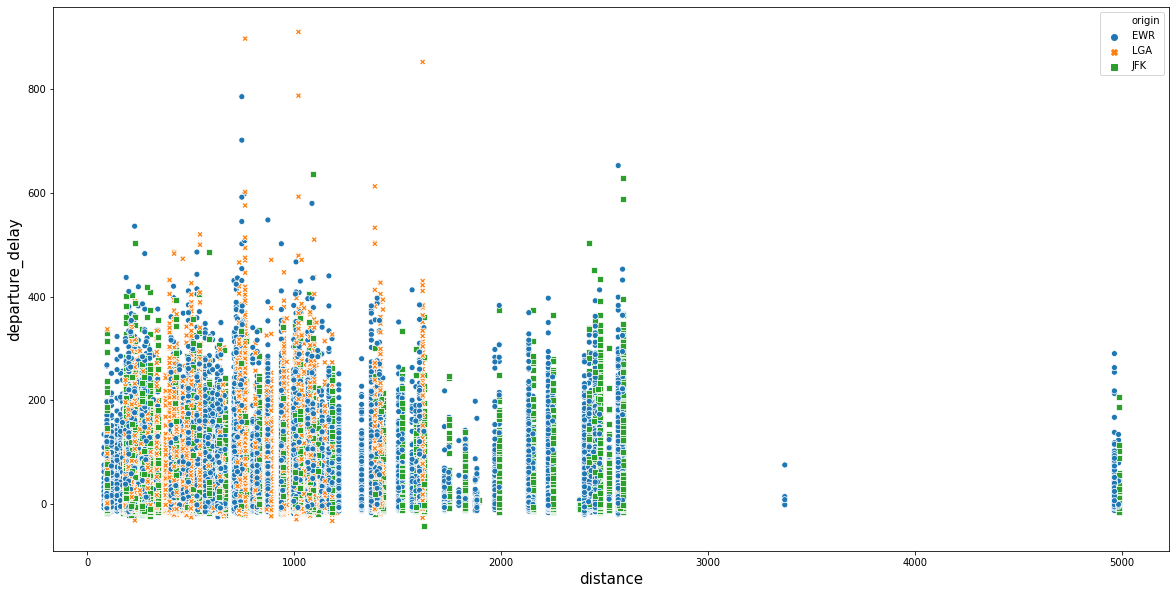

In [25]:
scatter_by_airport("distance", "departure_delay")

In the above plot, distance seems to have no influence whatsoever to departure_delay, but just to make sure we will do a linear regression to see what the regression coefficient would be.

In [26]:
def get_linear_regr_coef(data, xaxis, yaxis, stats = False):
    regr = linear_model.LinearRegression()
    regr.fit(data[xaxis].to_numpy().reshape(-1,1), data[yaxis].to_numpy())
    print('The linear regression coefficient in sklearn is', regr.coef_[0])
    if stats:
        est = sm.OLS(data[yaxis].to_numpy().reshape(-1,1), data[xaxis].to_numpy().reshape(-1,1))
        est2 = est.fit()
        print('The statsmodels statistics give \n', est2.summary())

In [27]:
def plot_linear_regr(data, xaxis, yaxis, stats = False):
    sns.jointplot( x=xaxis, y=yaxis, data=data, size = 6, ratio = 6,
              joint_kws={'line_kws':{'color':'red'}}, kind='reg')
    plt.xlabel(xaxis, fontsize = 15)
    plt.ylabel(yaxis, fontsize = 15)
    plt.show()
    get_linear_regr_coef(data, xaxis, yaxis, stats)

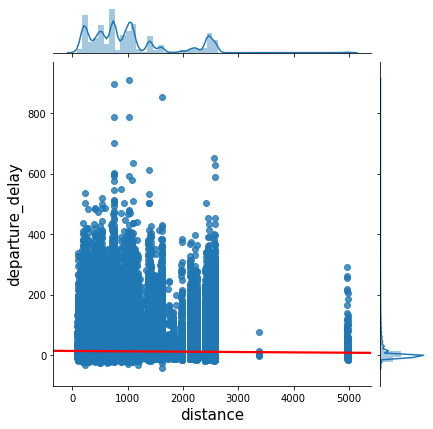

The linear regression coefficient in sklearn is -0.0011674450916430688
The statsmodels statistics give 
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.055
Model:                            OLS   Adj. R-squared (uncentered):              0.055
Method:                 Least Squares   F-statistic:                          1.852e+04
Date:                Sat, 18 Jan 2020   Prob (F-statistic):                        0.00
Time:                        14:26:15   Log-Likelihood:                     -1.6263e+06
No. Observations:              317996   AIC:                                  3.253e+06
Df Residuals:                  317995   BIC:                                  3.253e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
               

In [28]:
plot_linear_regr(working, "distance", "departure_delay", True)

This shows that on the whole, the influence of distance on departure_delay is almost nonexistant. According to the SKlearn model for every 1000 miles gained you lose 1 minute of flight delay.

### <a name="favourite"></a> 4 How to pick your favourite airport

In this section, we go into detail as to what airport is the best choice depending on your destination. Also we try to come up with other advice for travelers taking into account all the other columns in the database.

#### Time of day

I first create a new column called shifted_departure where the hours betwen 0:00 and 4:45 become hours between 24:00 - 28:45 because otherwise the linear regression will get confused by the hours near 0:00. 

In [29]:
working['shifted_departure'] = working['departure']
indexNames = working[working['departure']<445].index
working.loc[indexNames, 'shifted_departure']=working.loc[indexNames, 'shifted_departure'].add(2400)

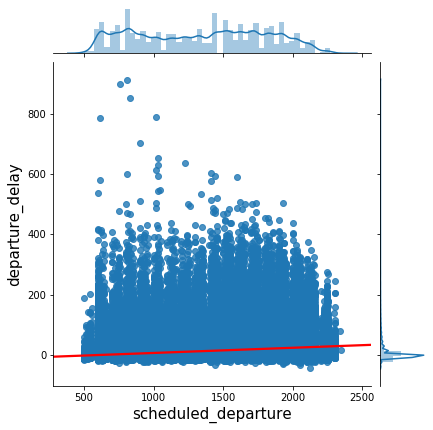

The linear regression coefficient in sklearn is 0.0171941151095251


In [30]:
plot_linear_regr(working, "scheduled_departure", "departure_delay")

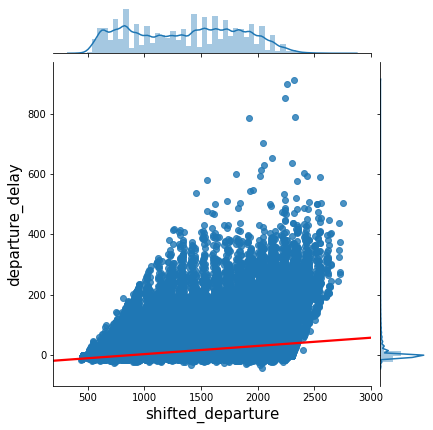

The linear regression coefficient in sklearn is 0.027225182947785937


In [31]:
plot_linear_regr(working, "shifted_departure", "departure_delay")

We can clearly see that the time of day matters a lot, as delay times get added up to flights later in the day. Let us see if the size of the airport makes a difference.

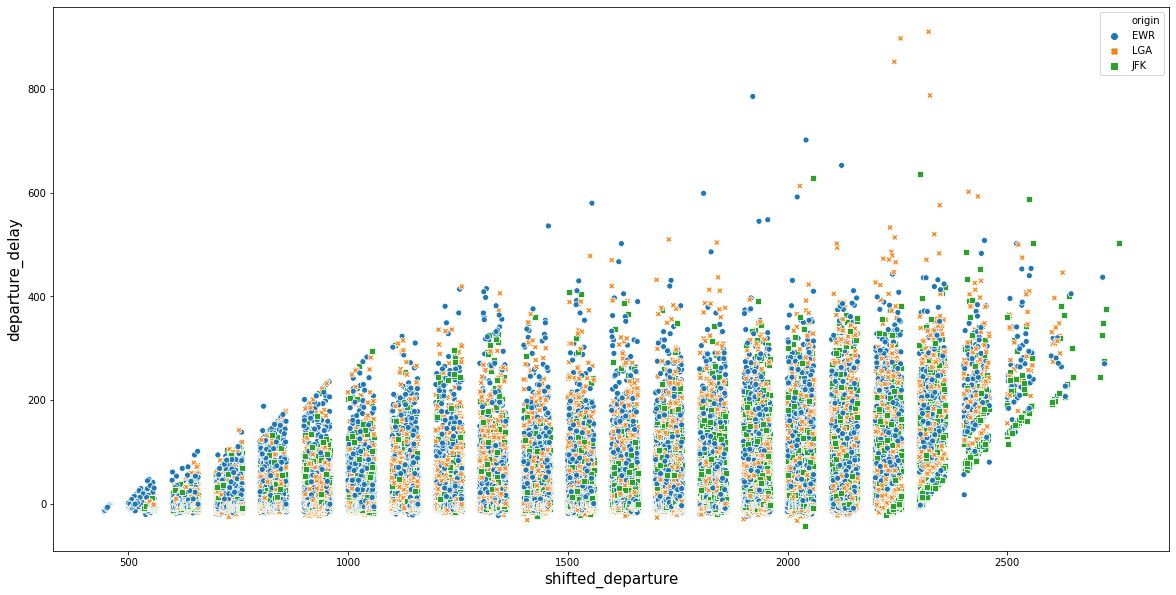

In [32]:
scatter_by_airport("shifted_departure", "departure_delay")

The graph above confirms the trend for each airport. Let us check by running a linear regression.

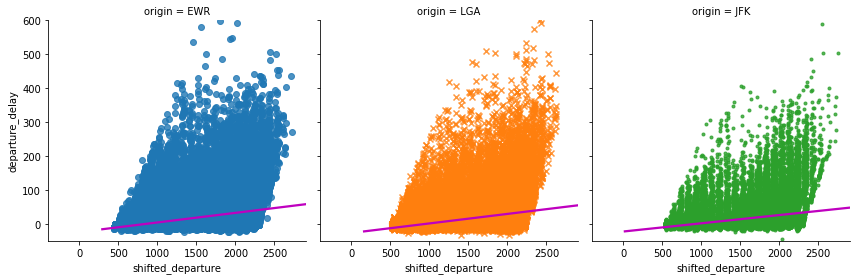

In [33]:
sns.lmplot(x="shifted_departure", y="departure_delay", hue="origin", col = "origin", data=working,
           markers=["o", "x", "." ], line_kws={'color':'m'}, height=4);
plt.ylim(-50, 600)
plt.xlim(-400, 2900)
plt.show()

In [34]:
print('For EWR')
get_linear_regr_coef(working[working['origin'] == 'EWR'], "shifted_departure", "departure_delay")
print('For LGA')
get_linear_regr_coef(working[working['origin'] == 'LGA'], "shifted_departure", "departure_delay")
print('For JFK')
get_linear_regr_coef(working[working['origin'] == 'JFK'], "shifted_departure", "departure_delay")

For EWR
The linear regression coefficient in sklearn is 0.028323978675818037
For LGA
The linear regression coefficient in sklearn is 0.028070846128548002
For JFK
The linear regression coefficient in sklearn is 0.024259337869068063


It does indeed make a difference. If you plan to fly later in the evening, EWR is a worse choice than either LGA and JFK.

#### Is it Christmas again?

Is the myth that winter traveling has more delays?

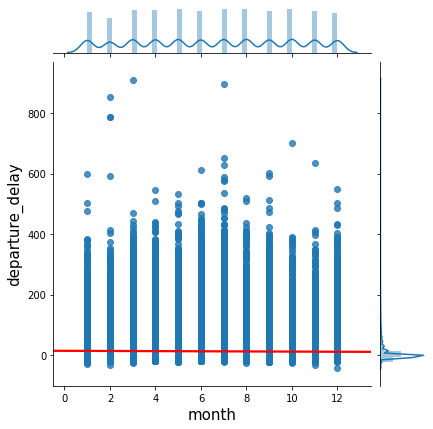

The linear regression coefficient in sklearn is -0.2586468118333994


In [35]:
plot_linear_regr(working, "month", "departure_delay")

From the plot it seems that summer traveling gathers more delays, but the coefficient doesn't say much. We should run a quadratic fit as the data seems more parabolic.

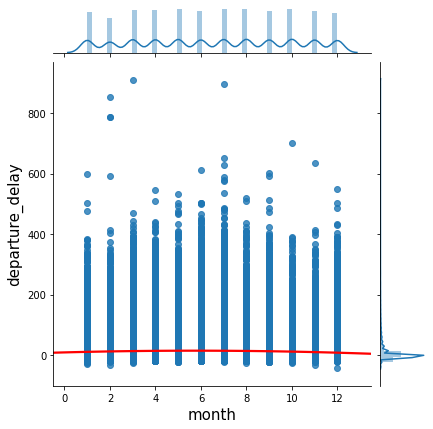

In [36]:
sns.jointplot( x="month", y="departure_delay", data=working, size = 6, ratio = 6, order = 2,
              joint_kws={'line_kws':{'color':'red'}}, kind='reg')
plt.xlabel("month", fontsize = 15)
plt.ylabel("departure_delay", fontsize = 15)
plt.show()

The quadratic plot doesn't show much difference either.

In [37]:
working['month_day'] = working['month']*30+working['day'] #trying to simulate the day of the year in an artificial way

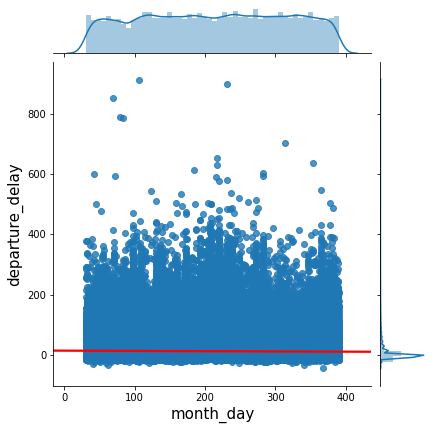

The linear regression coefficient in sklearn is -0.008524628551275067


In [38]:
plot_linear_regr(working, "month_day", "departure_delay")

The day of the year seems to not matter either. 

#### Should you change your airline?

In [39]:
get_stats_by_category('carrier','distance')

Total flights by carrier
carrier
UA    56298
EV    50847
B6    50001
DL    46082
AA    30435
MQ    24889
US    19721
9E    17212
WN    11983
VX     5086
FL     3155
AS      705
F9      677
YV      539
HA      337
OO       29
Name: origin, dtype: int64



Stats for departure delay by carrier
         min    max    count       mean        std
carrier                                           
UA       1.0  483.0  26321.0  29.949698  45.929194
EV       1.0  548.0  22859.0  50.171661  55.761595
B6       1.0  502.0  19681.0  40.296987  51.060097
DL       1.0  911.0  14724.0  36.957416  57.617762
AA       1.0  636.0   9612.0  36.677382  51.804844
MQ       1.0  486.0   7921.0  44.260826  49.702432
9E       1.0  430.0   6950.0  48.411367  57.730163
WN       1.0  471.0   6502.0  34.754076  52.814561
US       1.0  500.0   4747.0  32.954708  45.959874
VX       1.0  653.0   2202.0  34.206630  60.241815
FL       1.0  602.0   1633.0  40.703001  65.553418
F9       1.0  853.0    339.0  45.277286  74.7

We can see that some airlines, like EV and UA have a lot of flights and a lot of delayed flights, while DL is the champion with regards to making it on time even while having a lot of flights. Let's compare to see if the airport makes a difference when restricting to each carrier.

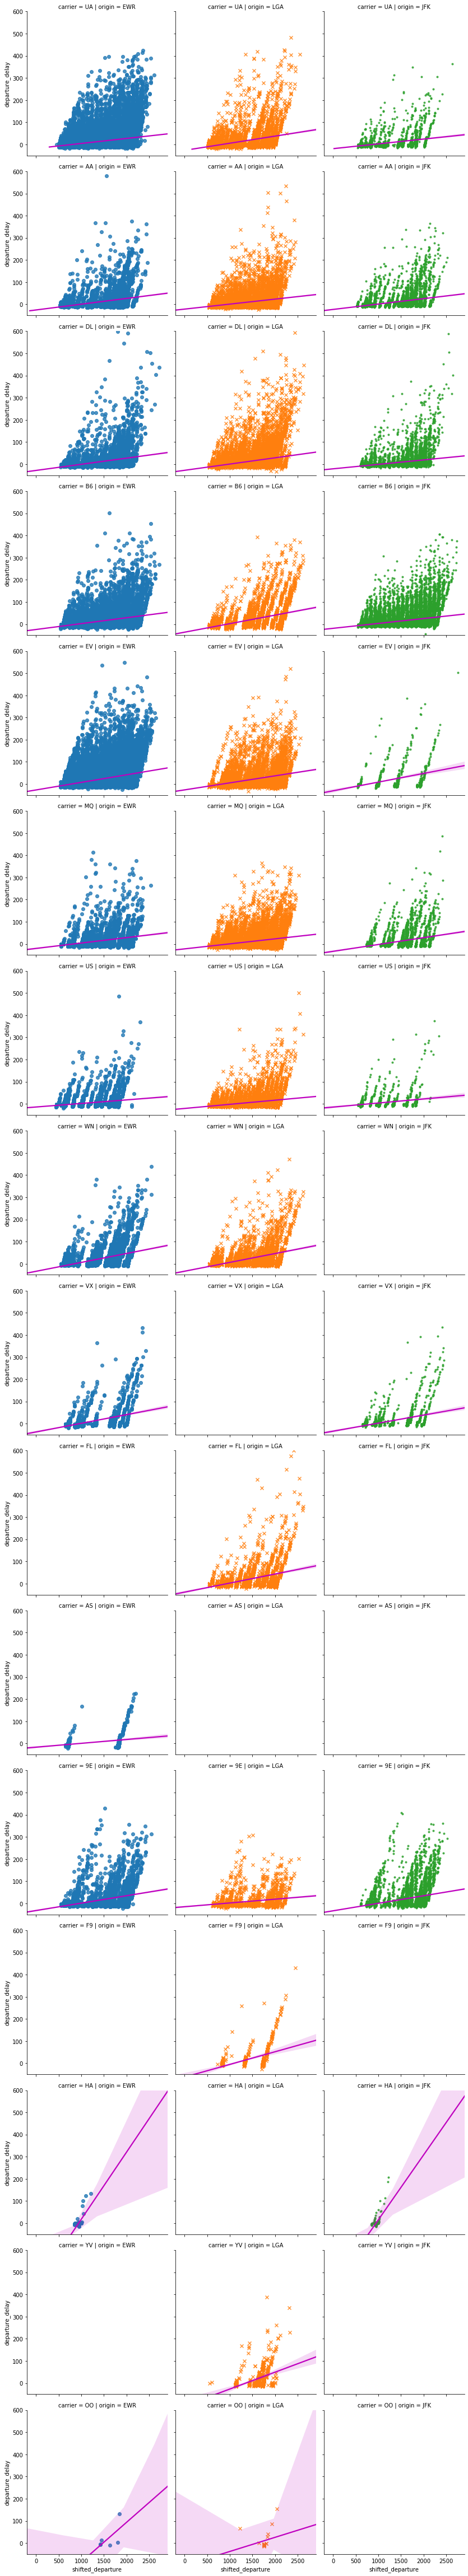

In [42]:
sns.lmplot(x="shifted_departure", y="departure_delay", hue="origin", row = "carrier", col = "origin", data=working,
           markers=["o", "x", "." ], line_kws={'color':'m'}, height=4);
plt.ylim(-50, 600)
plt.xlim(-200, 2900)
plt.show()


The graphs above show that the interplay between airline and airport is quite complicated. What seems to matter the most is just departure time. All airports tend to get crowded as the day moves on.

#### Specific advice depending on your destination

The following function generates a description for each route flying from an airport. The number after each route signifies the distance in hundreds of miles.

In [43]:
def get_routes(airport):
    temp = working[working['origin']==airport][['origin','destination','departure_delay','distance']]
    routes = dict()
    for ind, col in temp.iterrows():
        distance = int(col['distance']/100) #distance in multiples of 100 miles
        route = str(distance)+'-'+str(col['origin'])+'-'+str(col['destination'])
        if route in routes.keys():
            routes[route].append(col['departure_delay'])
        else:
            routes[route] = [col['departure_delay']]   
            
# transpose the dictionary in a list to sort the routes by distance        
    list_routes = []
    for key, value in routes.items():
        key_list = key.split('-')
        list_routes.append([int(key_list[0]), key_list[1], key_list[2] , value])
    list_routes.sort()
    return list_routes

def make_routes_plots(airport):
    means = [] ; stddevs = [] ; x_labels = [];
    routes = get_routes(airport)
    total_routes = len(routes)
    for distance, origin, destination, list_delays in routes:
    #_____________________________________________
    # set the labels as route + distance
        x_labels.append(origin+'-'+destination+'-'+str(distance))
    # compute mean and standard deviations
        means.append(scipy.mean(list_delays))
        stddevs.append(scipy.std(list_delays))
        
# plot the graph
    fig, ax = plt.subplots(figsize=(20,8))
    ax.errorbar(list(range(total_routes)), means, yerr = stddevs, fmt='o') 
    ax.set_title('Mean route delays for "{}"'.format(airport),
             fontsize=12)
    plt.ylabel('Mean delay at origin (minutes)', fontsize=12)

# and set the tick parameters
    plt.ylim(-50, 100)
    xticks = []
    for j in range(len(x_labels)):
        if x_labels[j] == x_labels[j-1]: continue
        xticks.append(j)
  
    ax.set_xticks(xticks)
    ax.set_xticklabels([x_labels[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 10)
    plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
    ax.tick_params(axis='y', which='major')

    plt.show()

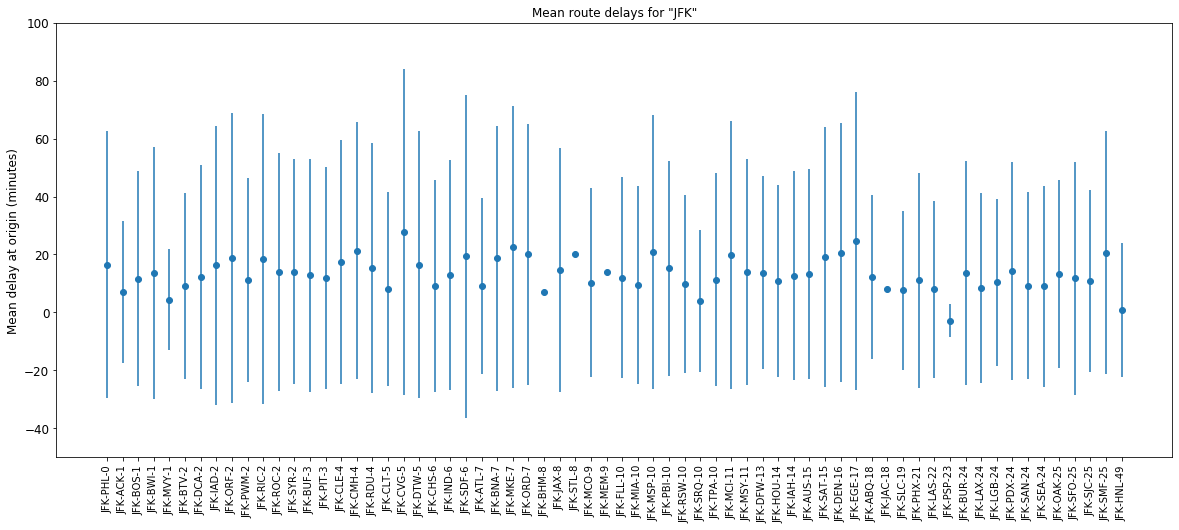

In [44]:
make_routes_plots('JFK')

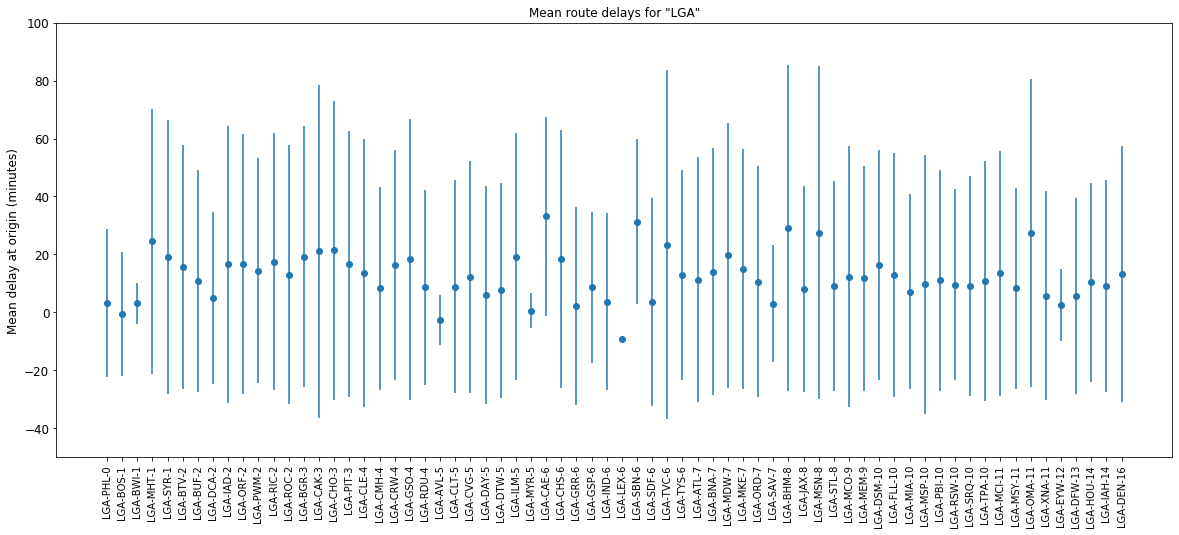

In [45]:
make_routes_plots('LGA')

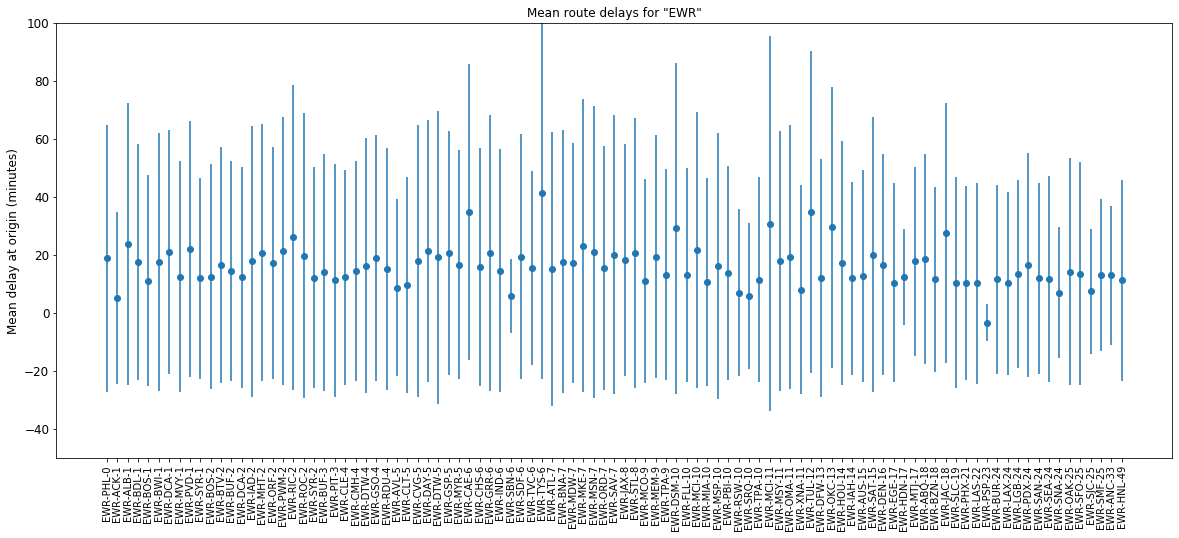

In [46]:
make_routes_plots('EWR')

These graphs are full of information, but for example one can see that if you would like to fly to Philly, your best bet is going from JFK as the delays are small on average with a small variation. If you want to go to San Francisco, you have to fly from EWR or JFK and the flights have similar statistics. 

The above graphs again prove that distance has nothing to do with delay times.

#### What about the weather?

I expect weather to not have such a big influence on flights, except for a rainy or snowy days, because the technology advanced sufficiently so that air traffic is not disturbed by low temperature and wind.

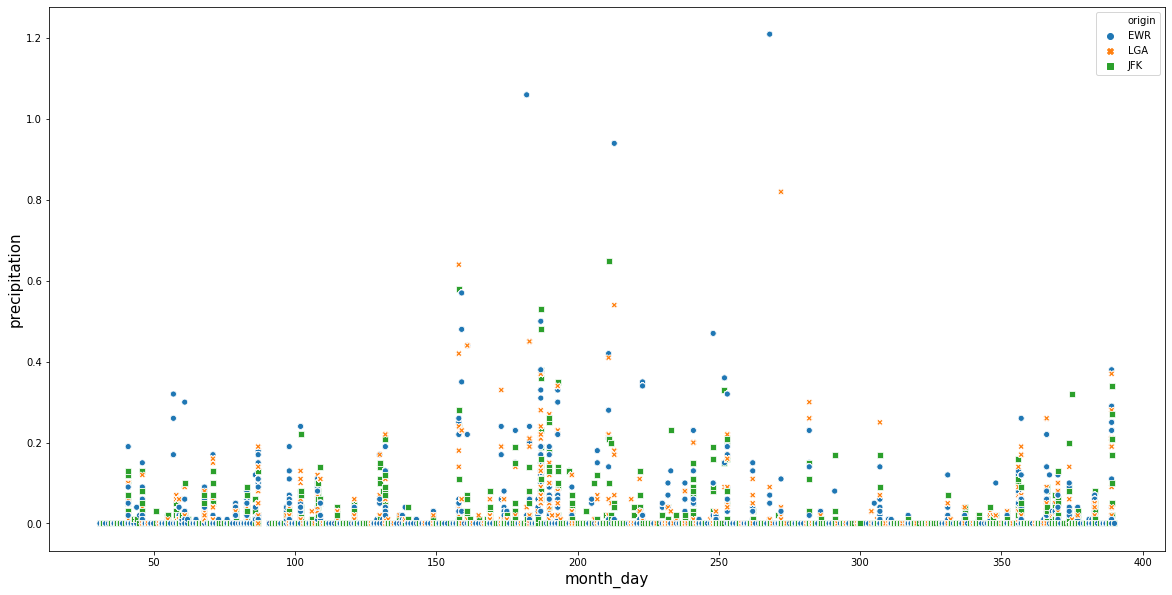

In [47]:
scatter_by_airport("month_day", "precipitation")

The airports are getting more or less the same amount of precipitation during the year. 

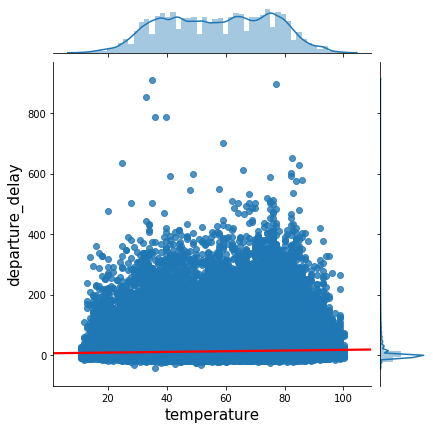

The linear regression coefficient in sklearn is 0.11380577980640941


In [50]:
temperature = working[working["temperature"]>0]
plot_linear_regr(temperature, "temperature", "departure_delay") #temperature > 0 to eliminate the data I filled in at the beginning

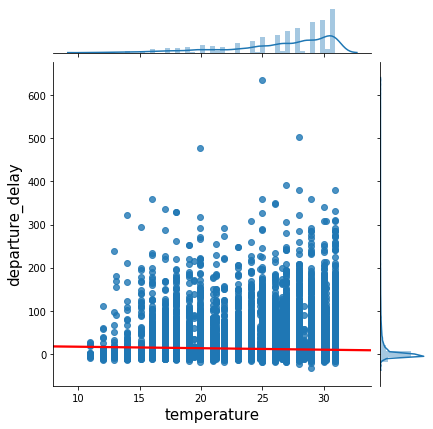

The linear regression coefficient in sklearn is -0.3447161544481305


In [51]:
plot_linear_regr(temperature[temperature["temperature"]<32], "temperature", "departure_delay")

Temperature has a small effect, as it is easier to prepare the planes on a hot day than on a really cold day. Surprinsingly really cold days do not have that much delay. 

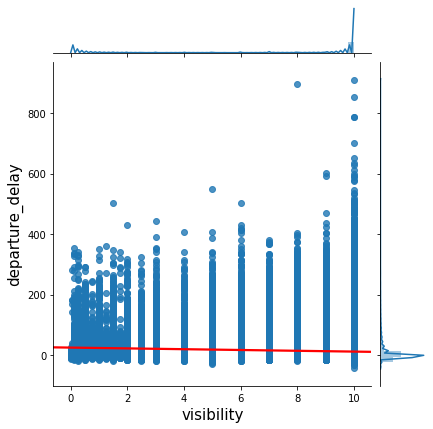

The linear regression coefficient in sklearn is -1.3219558358660768


In [52]:
plot_linear_regr(working, "visibility", "departure_delay")

Visibility (fog) seems to play an important role as expect, the higher the visibility the smaller the delay.

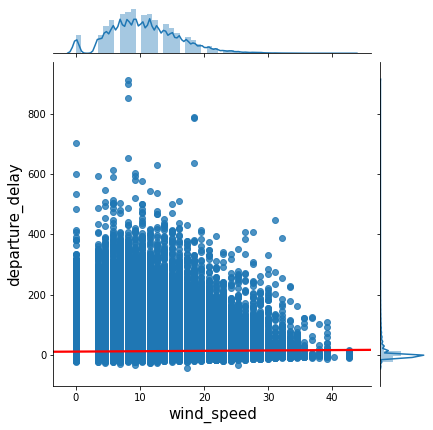

The linear regression coefficient in sklearn is 0.12580124800524742


In [53]:
plot_linear_regr(working, "wind_speed", "departure_delay")

This is an interesting graph. It may seems that the departure delay decreases as the wind decreases, but this is just an artifact from the data. New York is not a very windy city so we have way more data for small wind_speeds than for large wind speeds.

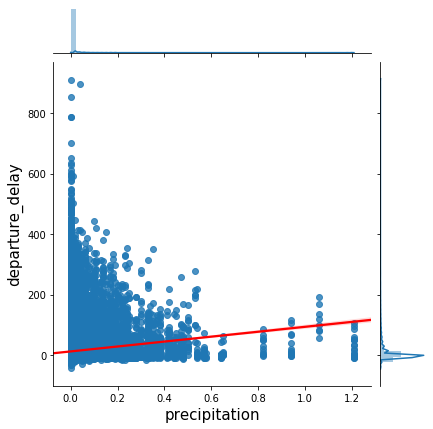

The linear regression coefficient in sklearn is 81.28899069481577


In [54]:
plot_linear_regr(working, "precipitation", "departure_delay")

This graph is very interesting, it might be the snow so let's check what happens on days with under 32F.

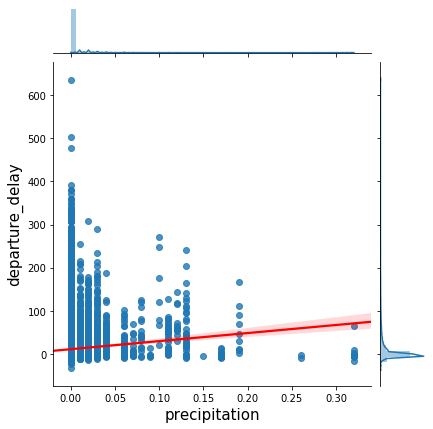

The linear regression coefficient in sklearn is 187.3383745392877


In [55]:
plot_linear_regr(working[working["temperature"]<33], "precipitation", "departure_delay")

Somebody needs to clean the tarmac of snow before plane takes off, so delays increase.

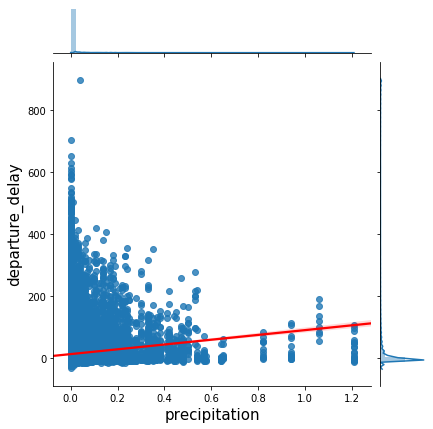

The linear regression coefficient in sklearn is 77.2330469602626


In [56]:
plot_linear_regr(working[working["temperature"]>50], "precipitation", "departure_delay")

Rain also seems to have an impact, but, as expected, it is not as strong as that of snow.

#### <a name='conclusion'></a> 5. Conclusion




If you are flying from NY and don't want to experience the dreaded delays:

* **most importantly: Wake up early!**
* Don't wish for snow! Why would you want to leave NY if it's snowing anyways?
* Avoid Newark if you really hate delays no matter how small, most flights from there have some delay.
* Reconsider whether it is time to let go your favourite airline.
* Consider for how long you need to be in the NY traffic to get to your favourite airport (personal experience, the traffic study is for another time).